In [2]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from RTRBM.RTRBM_batches import RTRBM

### Binary Network

In [2]:
def create_weights_binary_network(N=10, phigh=0.5, ilow=-0.5):
    # initialize NxN weight matrix
    Wa = np.random.uniform(high=phigh, size=(N//2,N//2))
    Wb = np.random.uniform(high=phigh, size=(N//2,N//2))
    for i in range(N//2):
        Wa[i,i] = 0
        Wb[i,i] = 0

    # create large matrix W
    W = np.zeros(shape=(N,N))
    W[0:N//2, 0:N//2] = Wa
    W[N//2:N, N//2:N] = Wb

    # add negative connection between subgroups
    Wc = np.random.uniform(low=ilow, high=0, size=(N//2,N//2))
    Wd = np.random.uniform(low=ilow, high=0, size=(N//2,N//2))
    W[0:N//2, N//2:N] = Wc
    W[N//2:N, 0:N//2] = Wd

    return W

In [3]:
N_neurons = 20
weights = create_weights_binary_network(N=N_neurons, phigh=2, ilow=-4)/N_neurons

<AxesSubplot:>

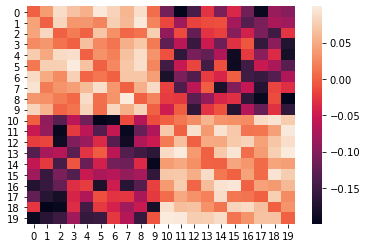

In [4]:
sns.heatmap(weights)

In [5]:
Tmax = 1000
spikes = np.zeros(shape=(N_neurons,Tmax))
spikes[:, 0] = np.random.choice([0,1],size=(N_neurons))

for t in range(1,Tmax):
    spikes[:,t] = np.random.random(N_neurons) < (spikes[:,t-1]@weights + np.random.uniform(0,0.5,size=N_neurons))

In [7]:
from RTRBM.RTRBM_batches import RTRBM
rtrbm = RTRBM(torch.tensor(spikes))
rtrbm.learn(10, learning_rate=1e-5)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.93it/s]


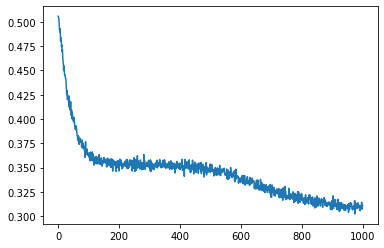

In [8]:
plt.plot(rtrbm.errors)

In [50]:
def plot_different_infer(model, data, train_test_split_line = 100):
    
    fig, ax = plt.subplots(5, figsize=(20,20))
    
    sns.heatmap(data, ax=ax[0], cbar=False)
    ax[0].set_title('True data')
    
    V, _ = model.infer(data[:,:train_test_split_line], pre_gibbs_k=0, gibbs_k=1, disable_tqdm=True)
    sns.heatmap(V, ax=ax[1], cbar=False)
    ax[1].set_title('1 Gibbs sample')
    
    V, _ = model.infer(data[:,:train_test_split_line], pre_gibbs_k=0, gibbs_k=10, mode=2, disable_tqdm=True)
    sns.heatmap(V, ax=ax[2], cbar=False)
    ax[2].set_title('mean of 10 Gibbs samples')
    
    V, _ = model.infer(data[:,:train_test_split_line], pre_gibbs_k=0, gibbs_k=100, mode=2, disable_tqdm=True)
    sns.heatmap(V, ax=ax[3], cbar=False)
    ax[3].set_title('mean of 100 Gibbs samples')
       
    V, _ = model.infer(data[:,:train_test_split_line], pre_gibbs_k=0, gibbs_k=100, mode=1, disable_tqdm=True)
    sns.heatmap(V, ax=ax[4], cbar=False)
    ax[4].set_title('last of 100 Gibbs samples')

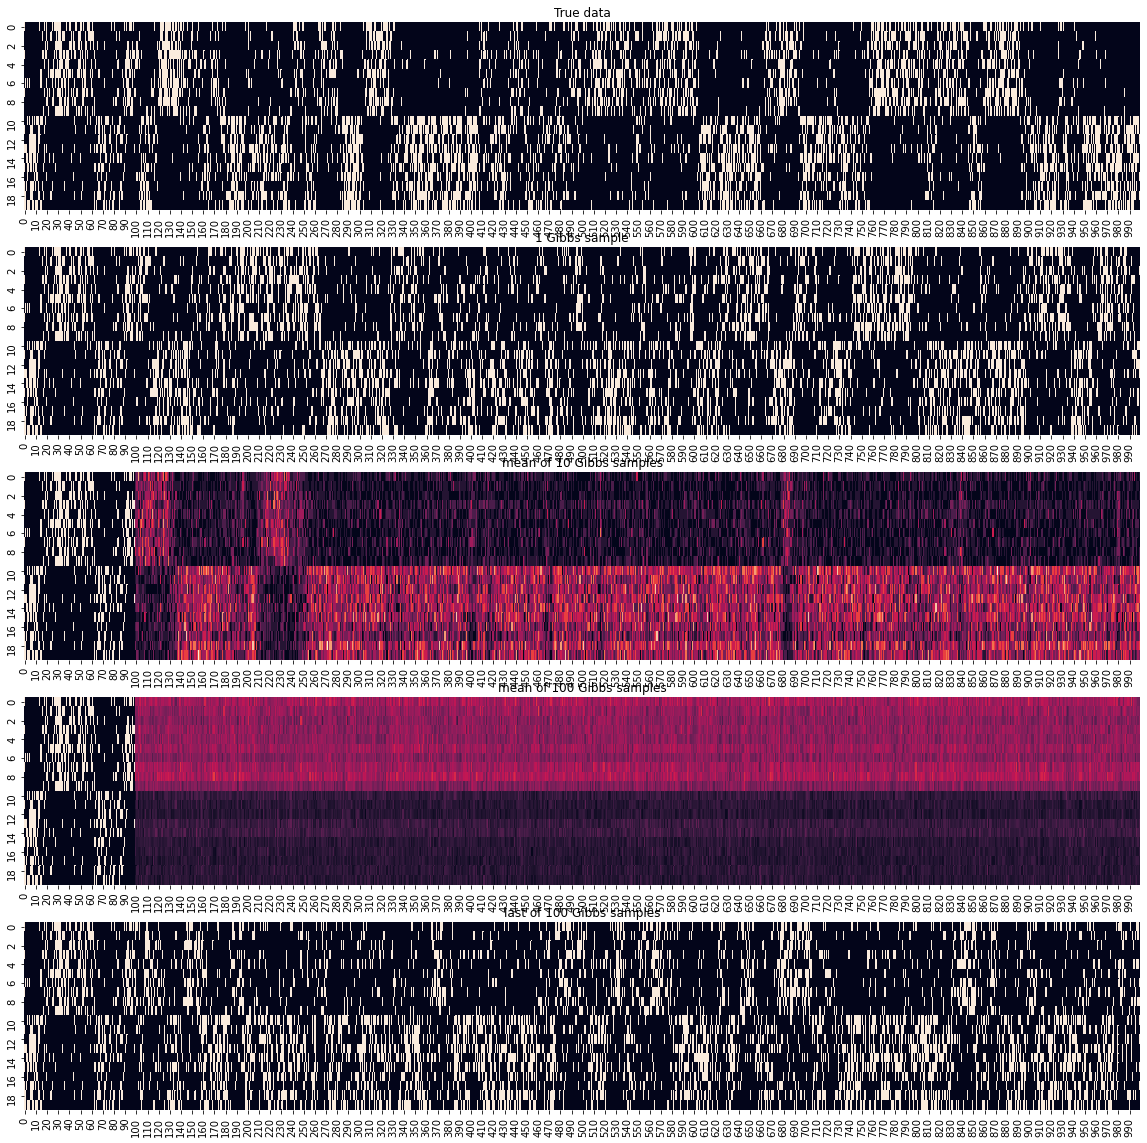

In [30]:
plot_different_infer(rtrbm, torch.tensor(spikes))

cRTRBM does capture binary dynamics

### Oscillating Network 

In [31]:
from data.manipulate_data import *

In [47]:
spikes, time_arr = generate_mock_data(20, 1000, average_firing_rate=0.2, stimulus_period=10)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.66it/s]


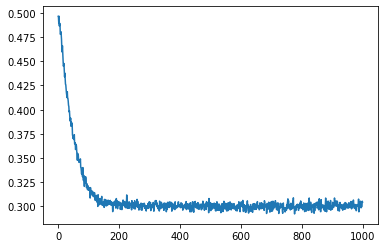

In [49]:
rtrbm = RTRBM(spikes)
rtrbm.learn(10, learning_rate=1e-5)
plt.plot(rtrbm.errors)

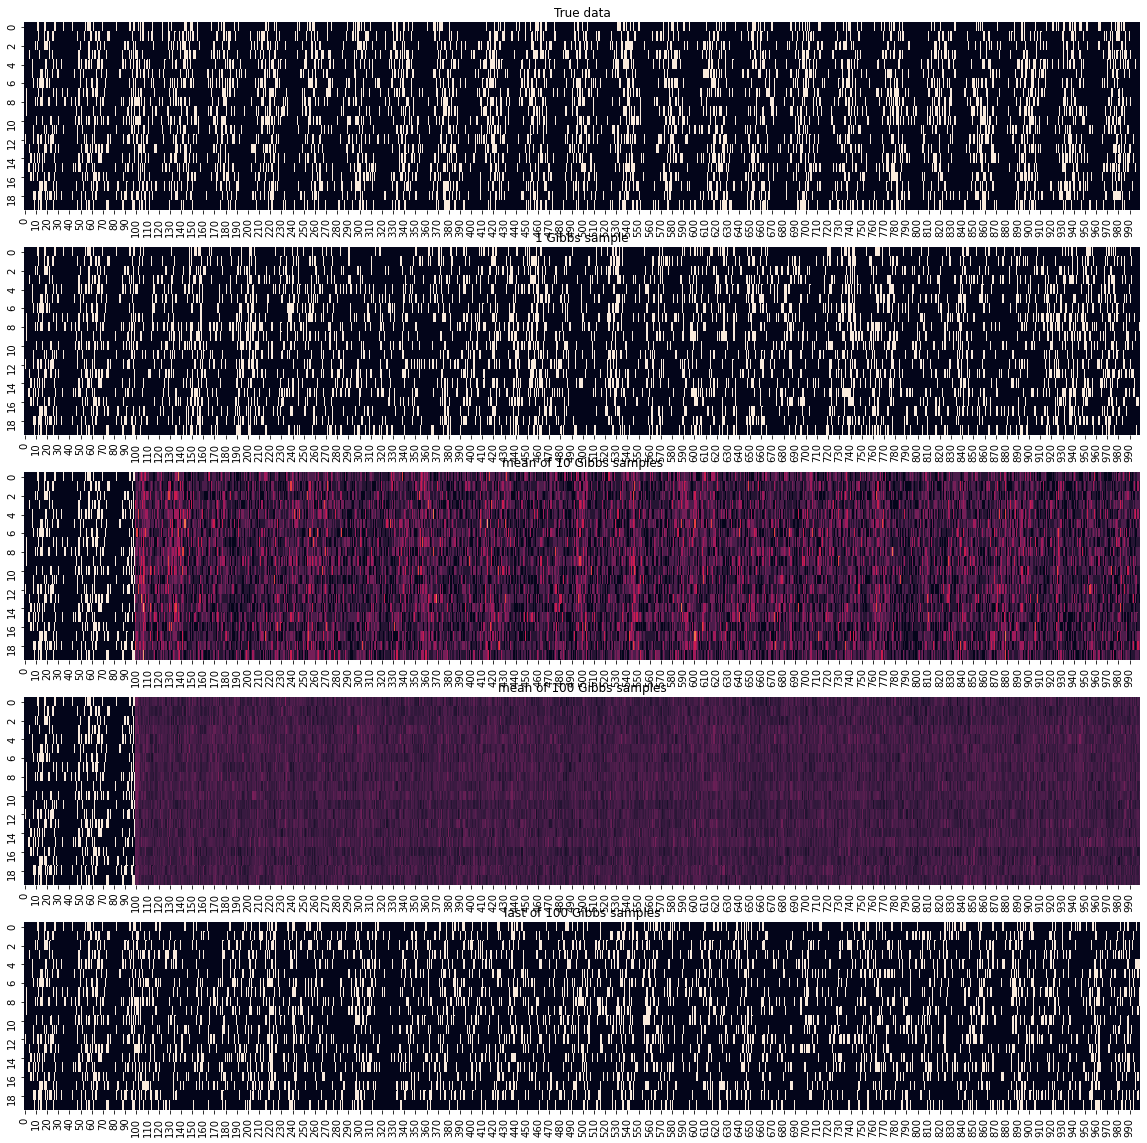

In [52]:
plot_different_infer(rtrbm, spikes)

rtrbm doesn't learn periodicity... Maybe more hidden nodes? N_H = 100:

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.60it/s]


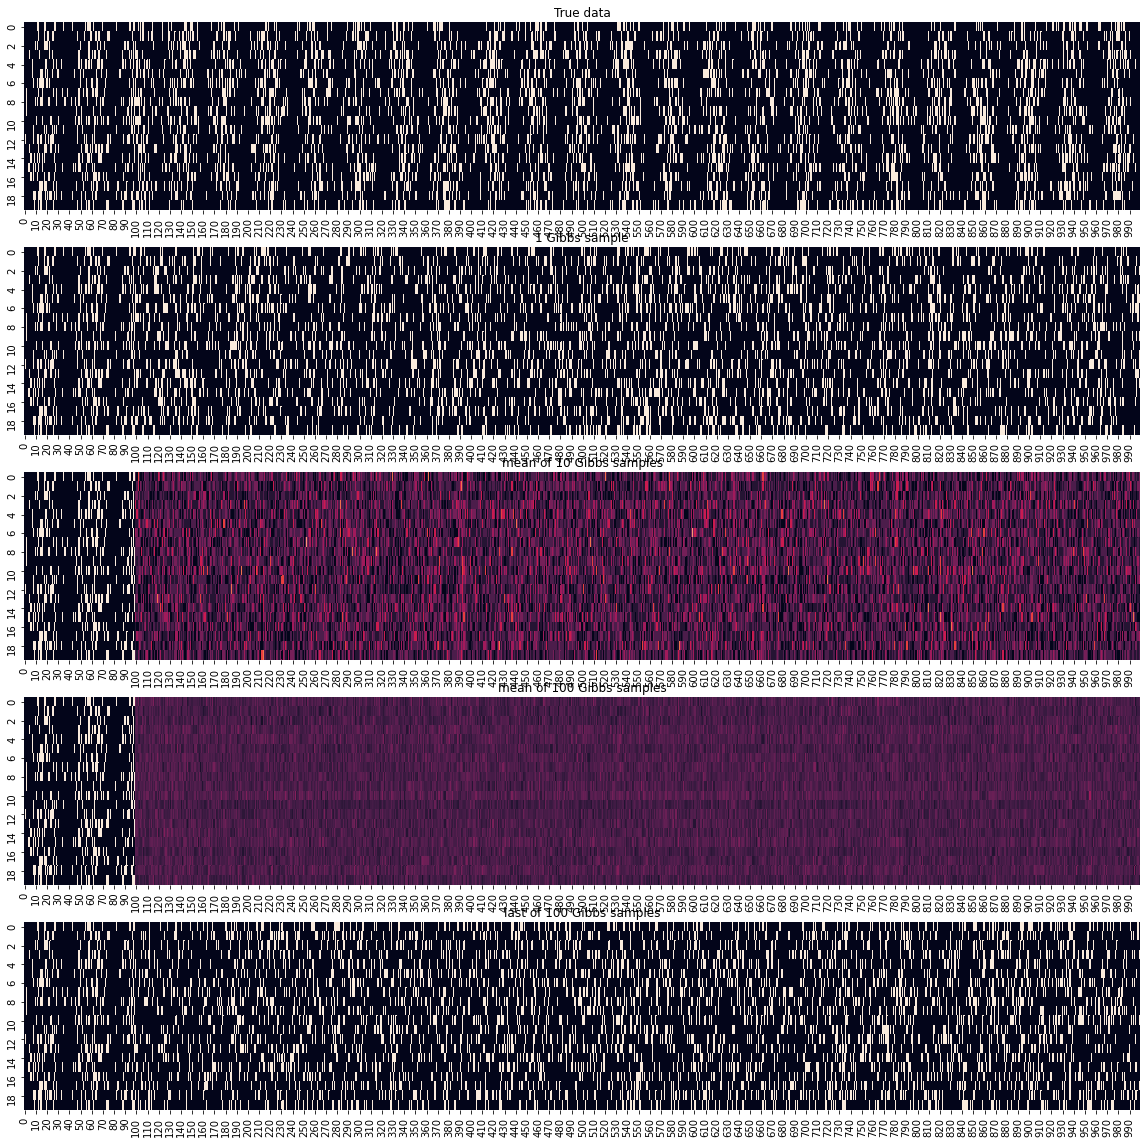

In [53]:
spikes, time_arr = generate_mock_data(20, 1000, average_firing_rate=0.2, stimulus_period=10)
rtrbm = RTRBM(spikes)
rtrbm.learn(100, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

overfitting? Less hidden nodes?

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 14.95it/s]


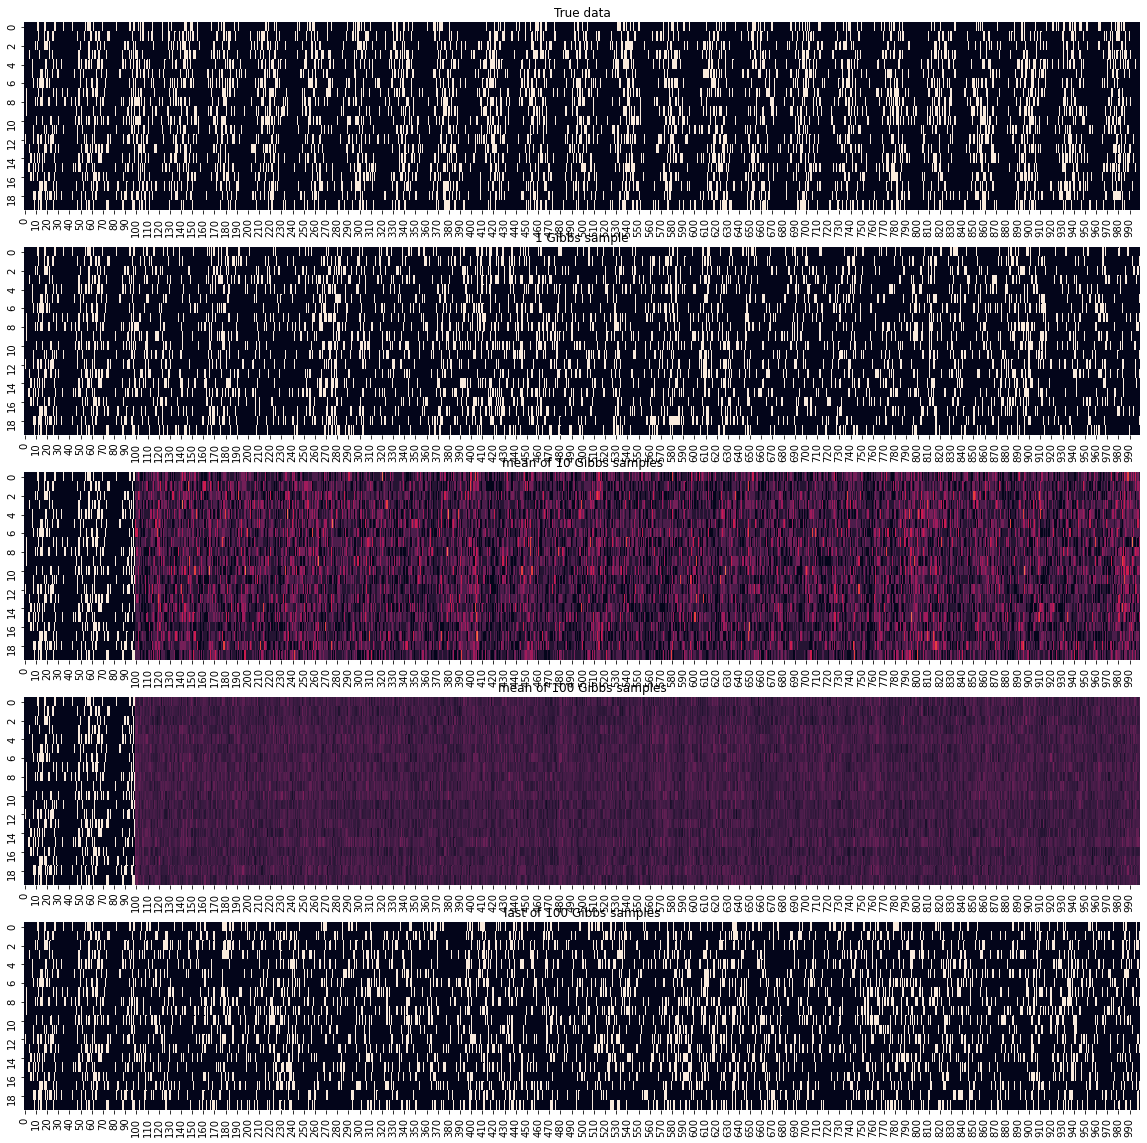

In [54]:
spikes, time_arr = generate_mock_data(20, 1000, average_firing_rate=0.2, stimulus_period=10)
rtrbm = RTRBM(spikes)
rtrbm.learn(4, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

maybe it doesn't work well because data is stochastic? lets test.

In [76]:
from scipy import signal

T=1000
N_V = 20
stimulus_period = 10
sampling_frequency = 4
average_firing_rate = 0.5
  
# set random seed
torch.random.manual_seed(0)

# calculate stimulus frequency
stimulus_frequency = 1 / stimulus_period

# create time array
time_arr = torch.linspace(0, T/sampling_frequency, T)

# calculate firing probability with triangle wave
firing_probability = torch.tensor(signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1)

# deterministic spike trains
spikes = average_firing_rate*torch.ones(N_V, T) > firing_probability.expand(N_V, T)
spikes = spikes.type(torch.DoubleTensor)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.77it/s]


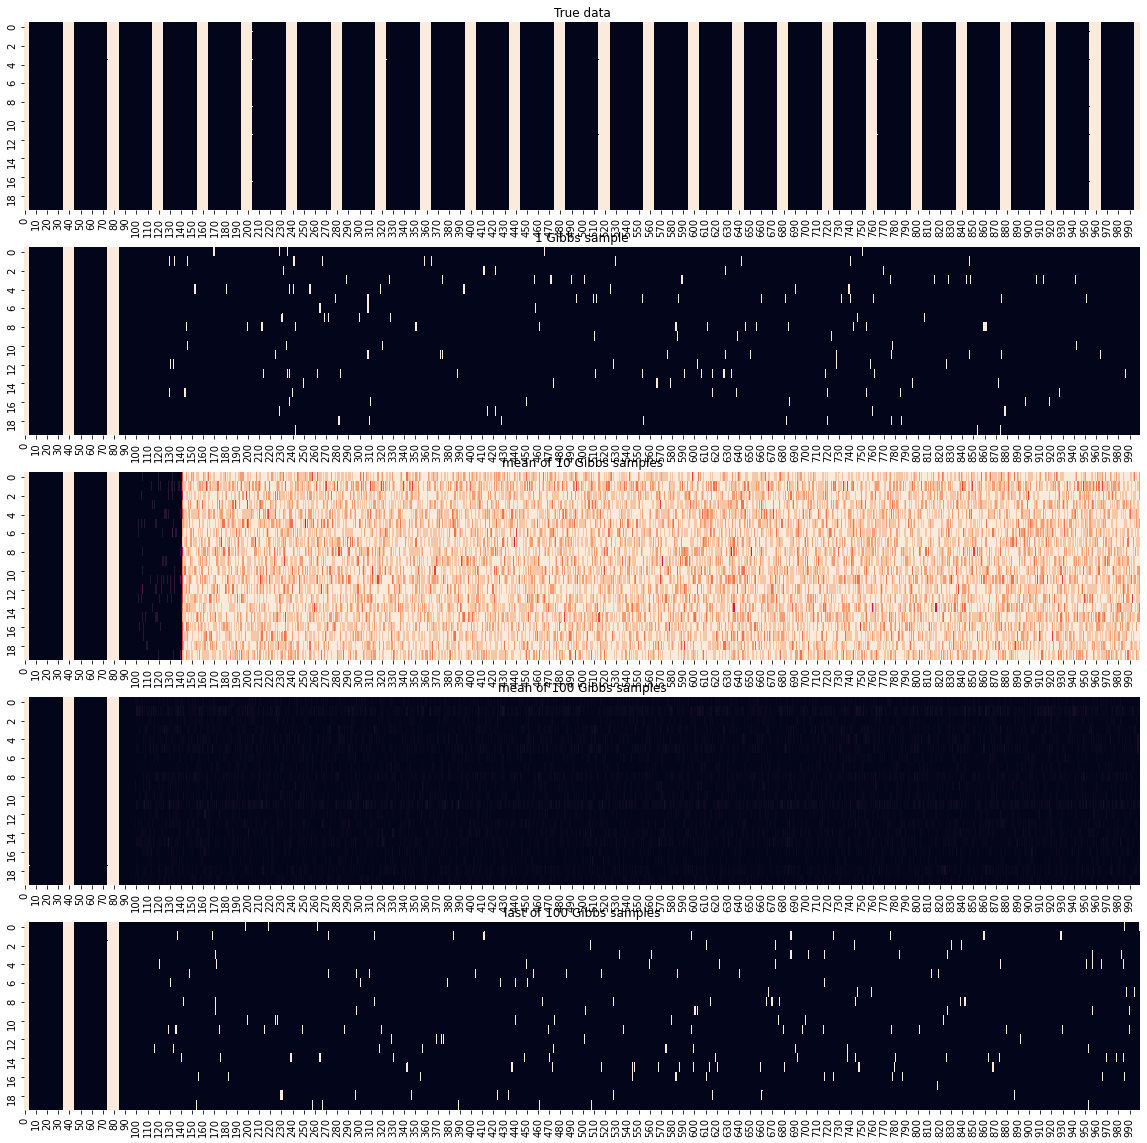

In [77]:
rtrbm = RTRBM(spikes)
rtrbm.learn(30, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

nope

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.10it/s]


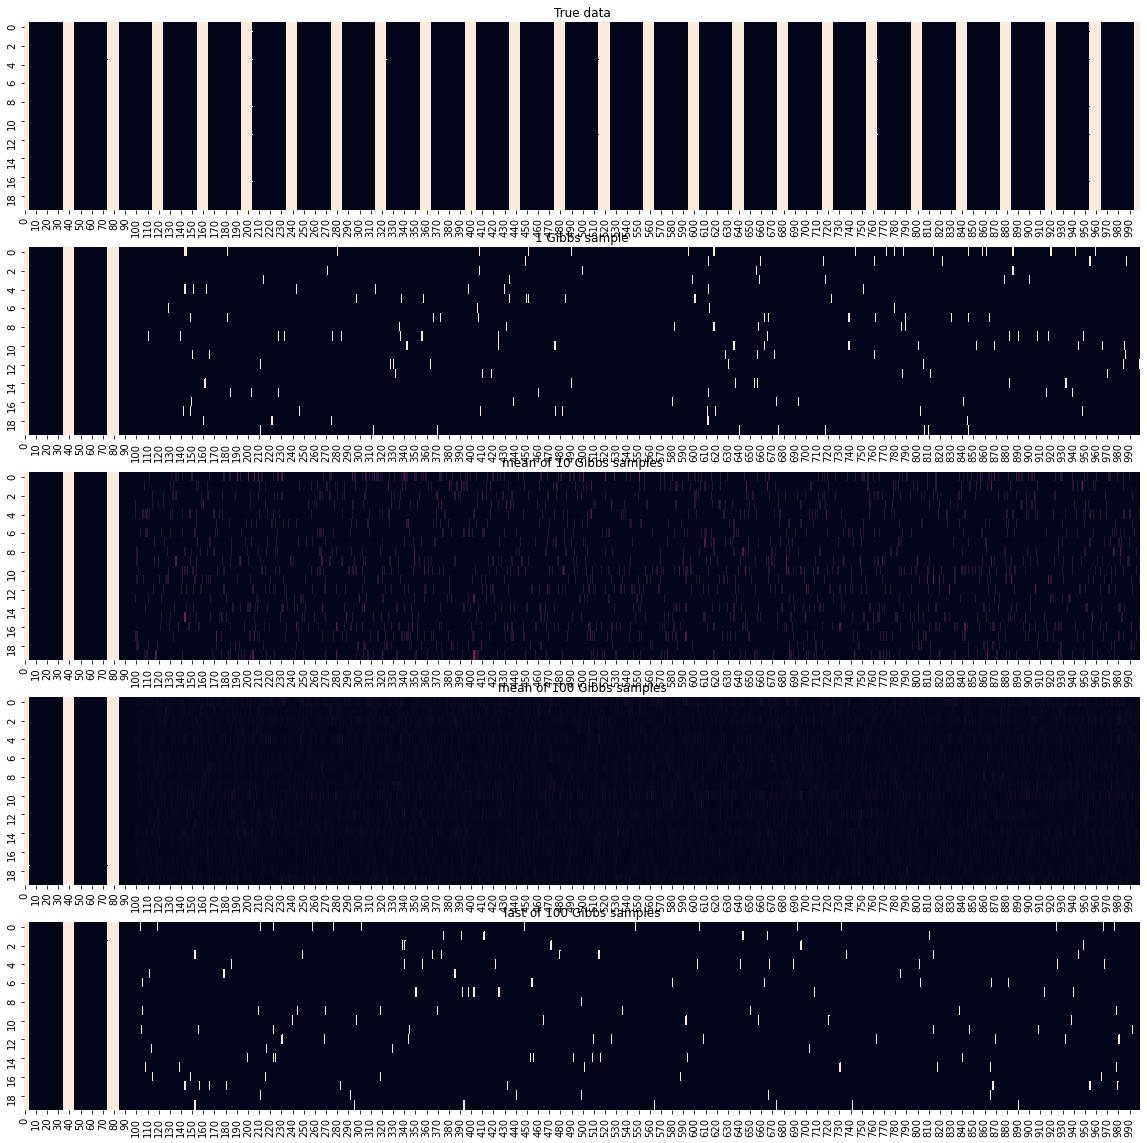

In [78]:
rtrbm = RTRBM(spikes)
rtrbm.learn(30, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

Note: this is the infer function (try to predict in the future, only use data T<500). The usual sampling procedure does work pretty well:

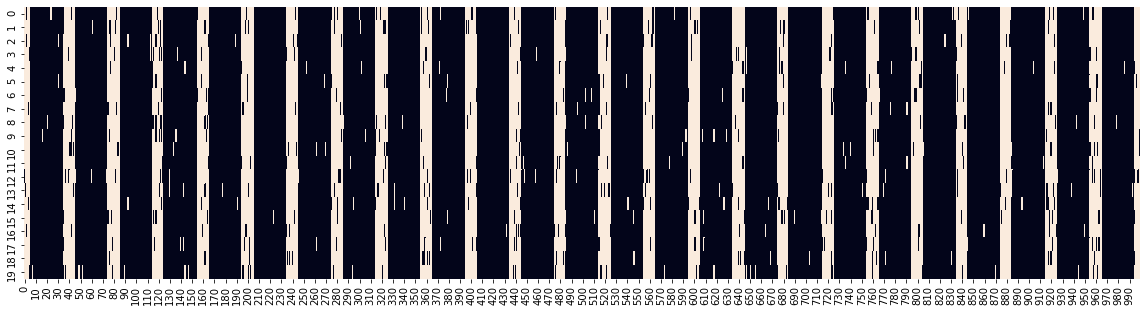

In [88]:
plt.figure(figsize=(20,5))
ax=sns.heatmap(rtrbm.v_infer, cbar=False)

### Sawtooth- like (looks like buoncing ball)

In [3]:
N_V = 20
T = 1000
period=10

n_on = np.arange(5, dtype=int)
g = np.ones(5, dtype=int)
spikes = torch.zeros(N_V, T, dtype=torch.float32)

for t in range(T):
    spikes[n_on,t] = 1
    n_on = n_on + g
    g[n_on <= 0] = 1
    g[n_on >= N_V-1] = -1


<AxesSubplot:>

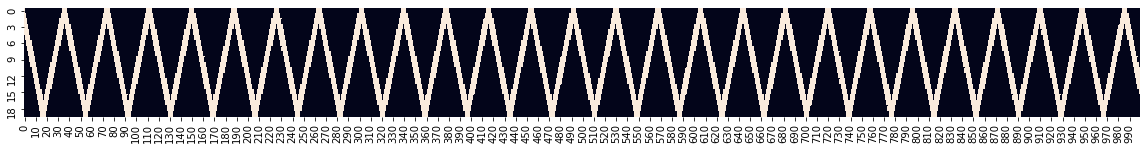

In [118]:
plt.figure(figsize=(20,2))
sns.heatmap(spikes, cbar=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.04it/s]


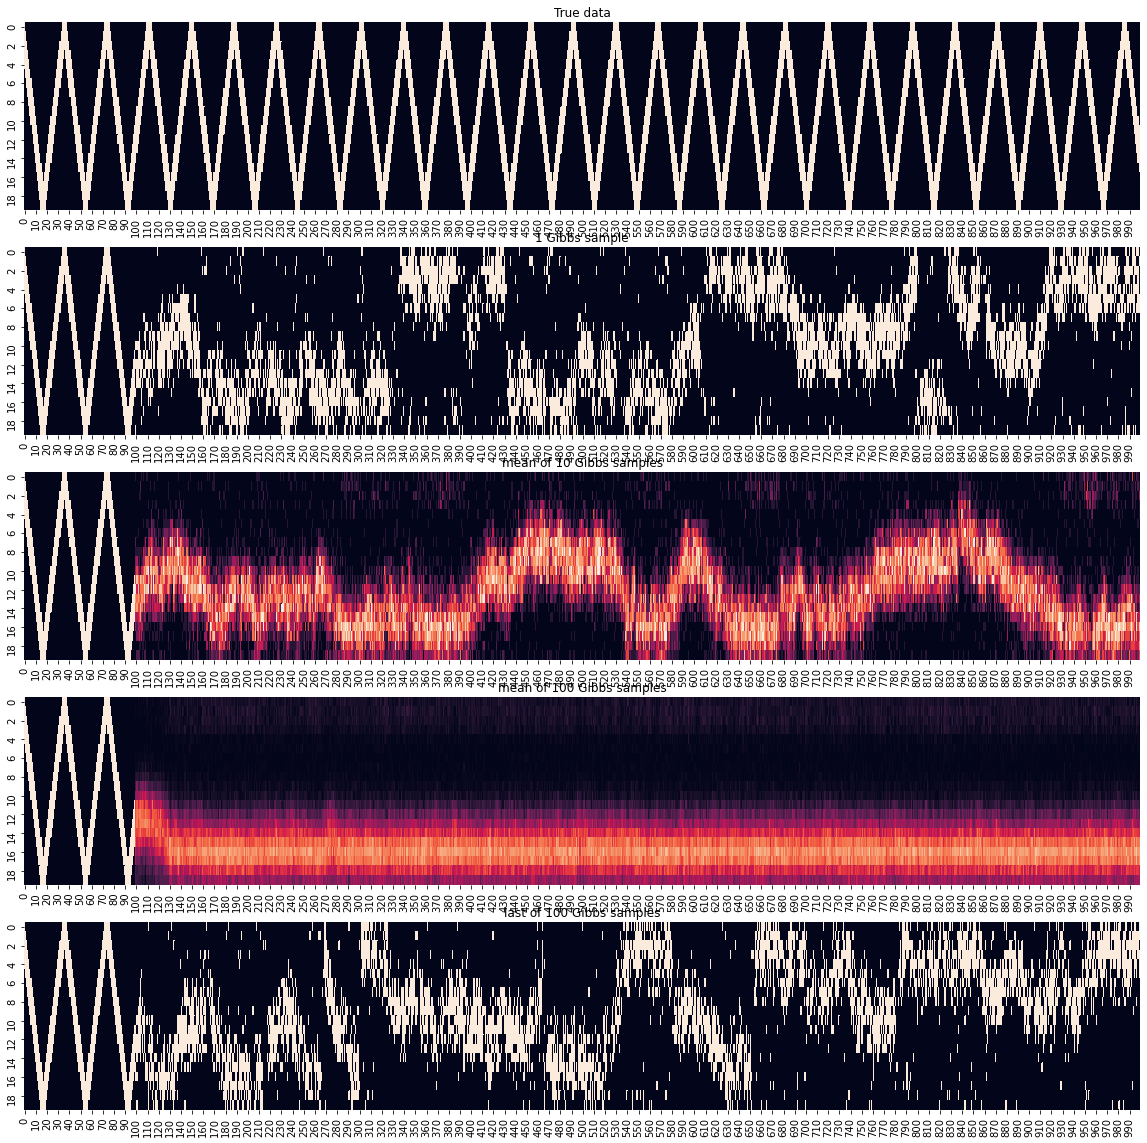

In [119]:
rtrbm = RTRBM(spikes)
rtrbm.learn(30, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.34it/s]


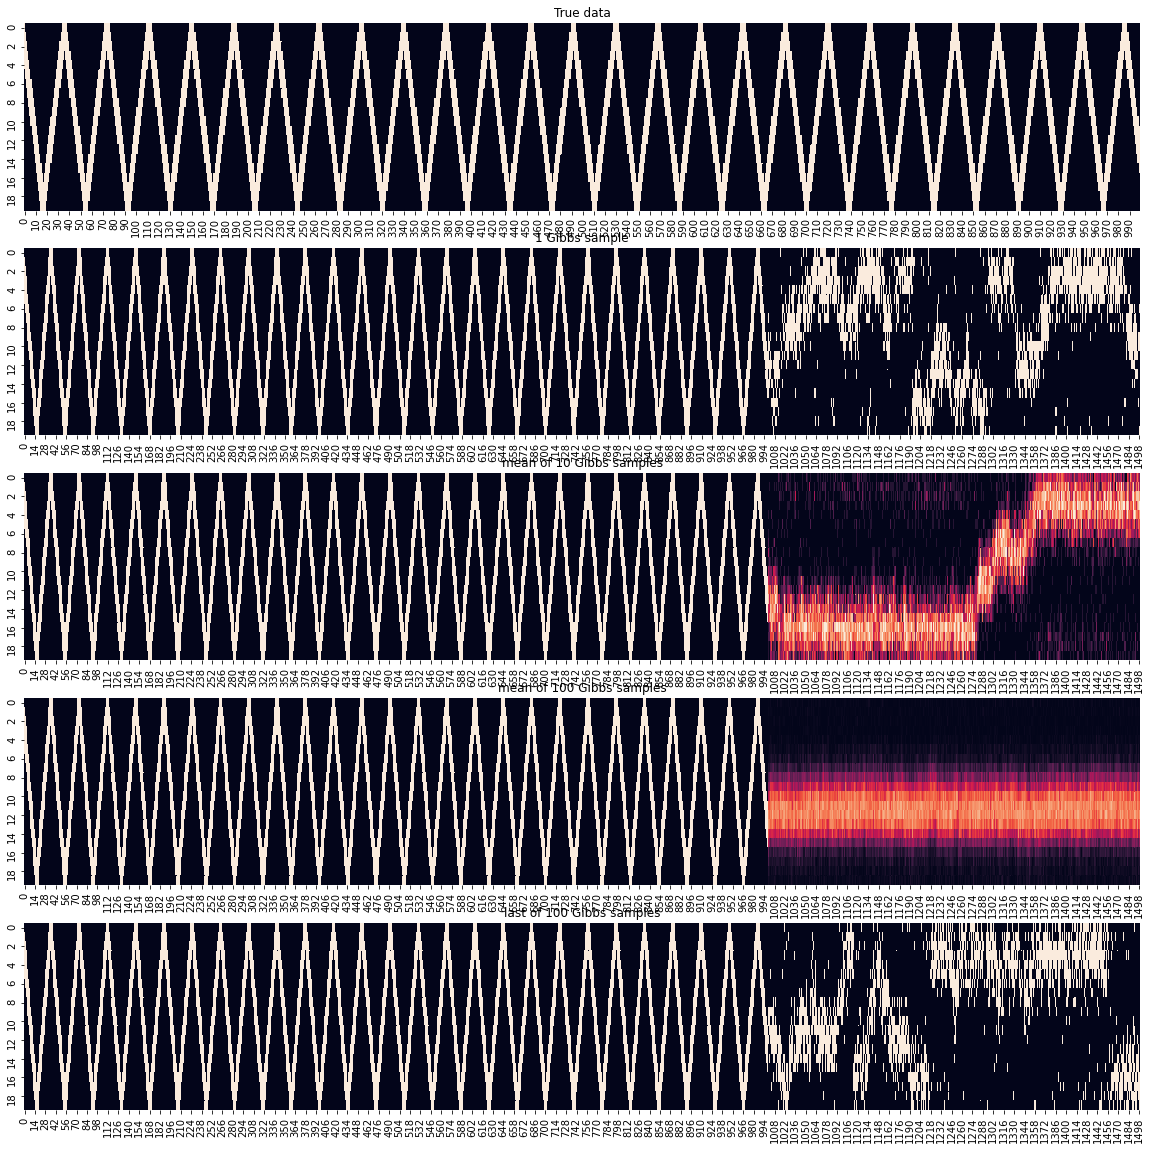

In [7]:
rtrbm = RTRBM(spikes)
rtrbm.learn(30, learning_rate=1e-5)
plot_different_infer(rtrbm, spikes)

### Bouncing Ball with no boundary conditions

In [1]:
import torch
import numpy as np

from RTRBM.RTRBM_batches_in_funcs import RTRBM
from data.manipulate_data import *
from utils.plots import *

In [2]:
data = create_BB(N_V=16, T=32, n_samples=256, width_vec=[4,5,6,7], velocity_vec=[1,2], boundary=False)
data = torch.tensor(data)
N_H = 8

In [3]:
rtrbm = RTRBM(data, N_H)
rtrbm.learn(learning_rate=1e-3, n_epochs=300, batchsize=16)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]


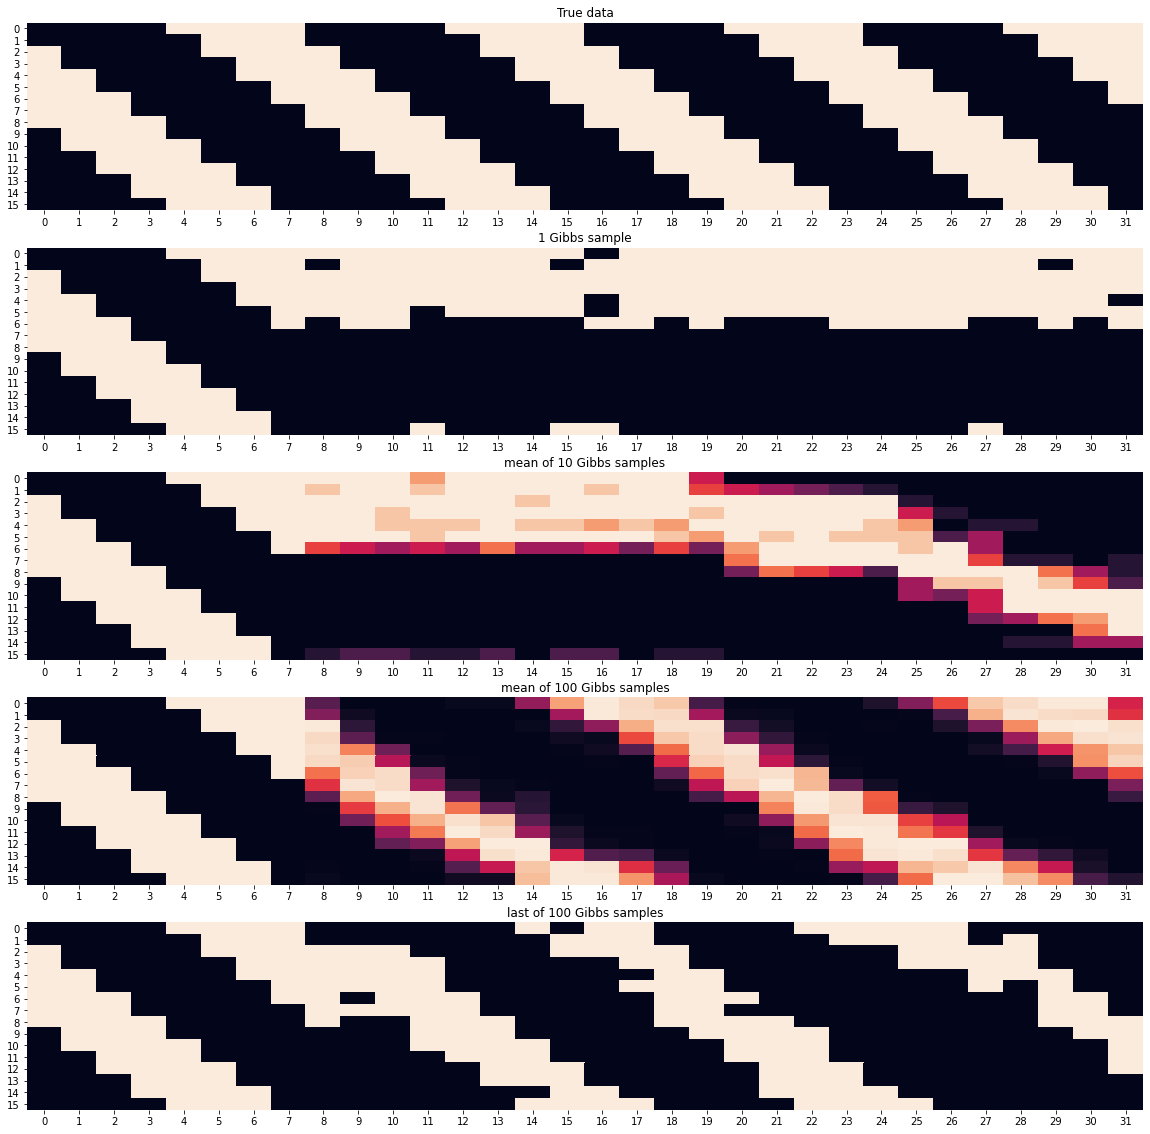

In [4]:
plot_different_infer(rtrbm, data[:,:,0], t_start_infer=8, t_extra=0)

### Bouncing Balls with boundaries

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [05:03<00:00,  1.01s/it]


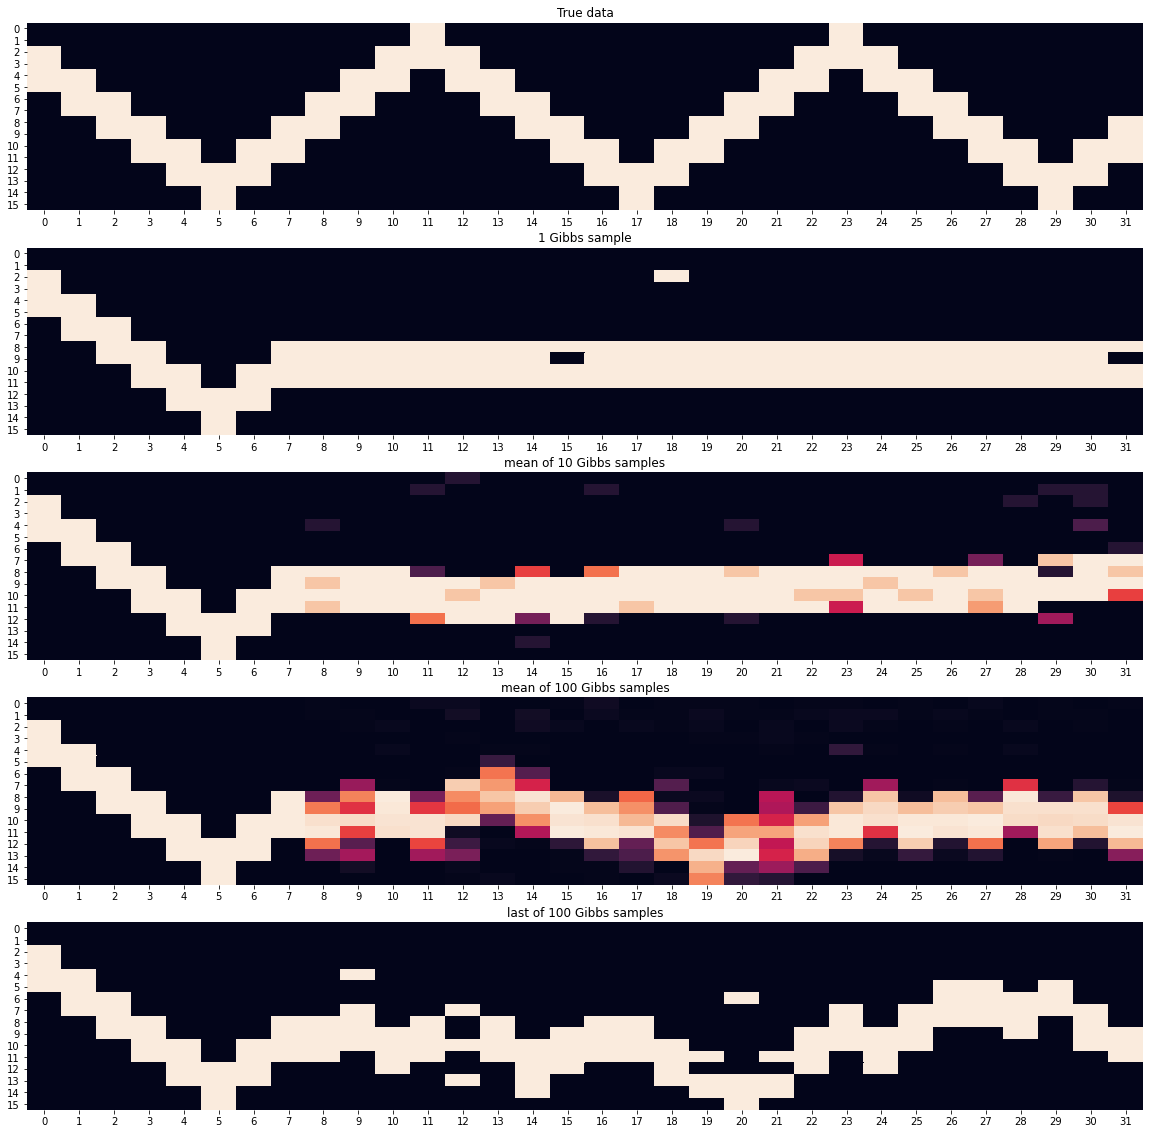

In [12]:
data = create_BB(N_V=16, T=32, n_samples=256, width_vec=[4,5,6,7], velocity_vec=[1,2], boundary=True)
data = torch.tensor(data)
N_H = 8

rtrbm = RTRBM(data, N_H)
rtrbm.learn(learning_rate=1e-3, n_epochs=300, batchsize=16)

plot_different_infer(rtrbm, data[:,:,0], t_start_infer=8, t_extra=0)

### Binary network + directed transitions 

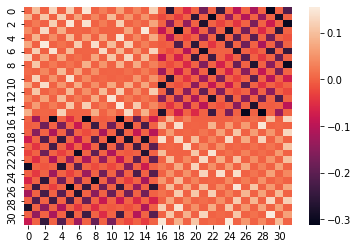

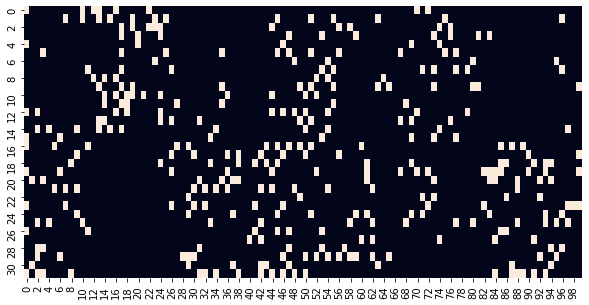

In [3]:
N_V = 32
n_batches = 10
T = 100
VH = create_weights_binary_network(phigh=5, ilow=-10, N=N_V) / N_V
VH_ = VH
for i in range(-N_V, N_V, 2):
    tmp = np.diagonal(VH, i)
    for j in tmp:
        VH_[VH==j] = 0
    tmp = []
sns.heatmap(VH_)
plt.show()

V = np.zeros([N_V, T, n_batches])
for batch in range(n_batches):
    T = 100
    V[:,0, batch] = torch.rand([N_V]) > 0.7
    for t in range(1,T):
        V[:,t, batch] = V[:, t-1, batch] @ VH_ + np.random.uniform(0,0.2,size=N_V) > np.random.random(N_V)


# plot first batch
plt.figure(figsize=(10,5))
sns.heatmap(V[:,:,0], cbar=False)

data = torch.tensor(V)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.29it/s]


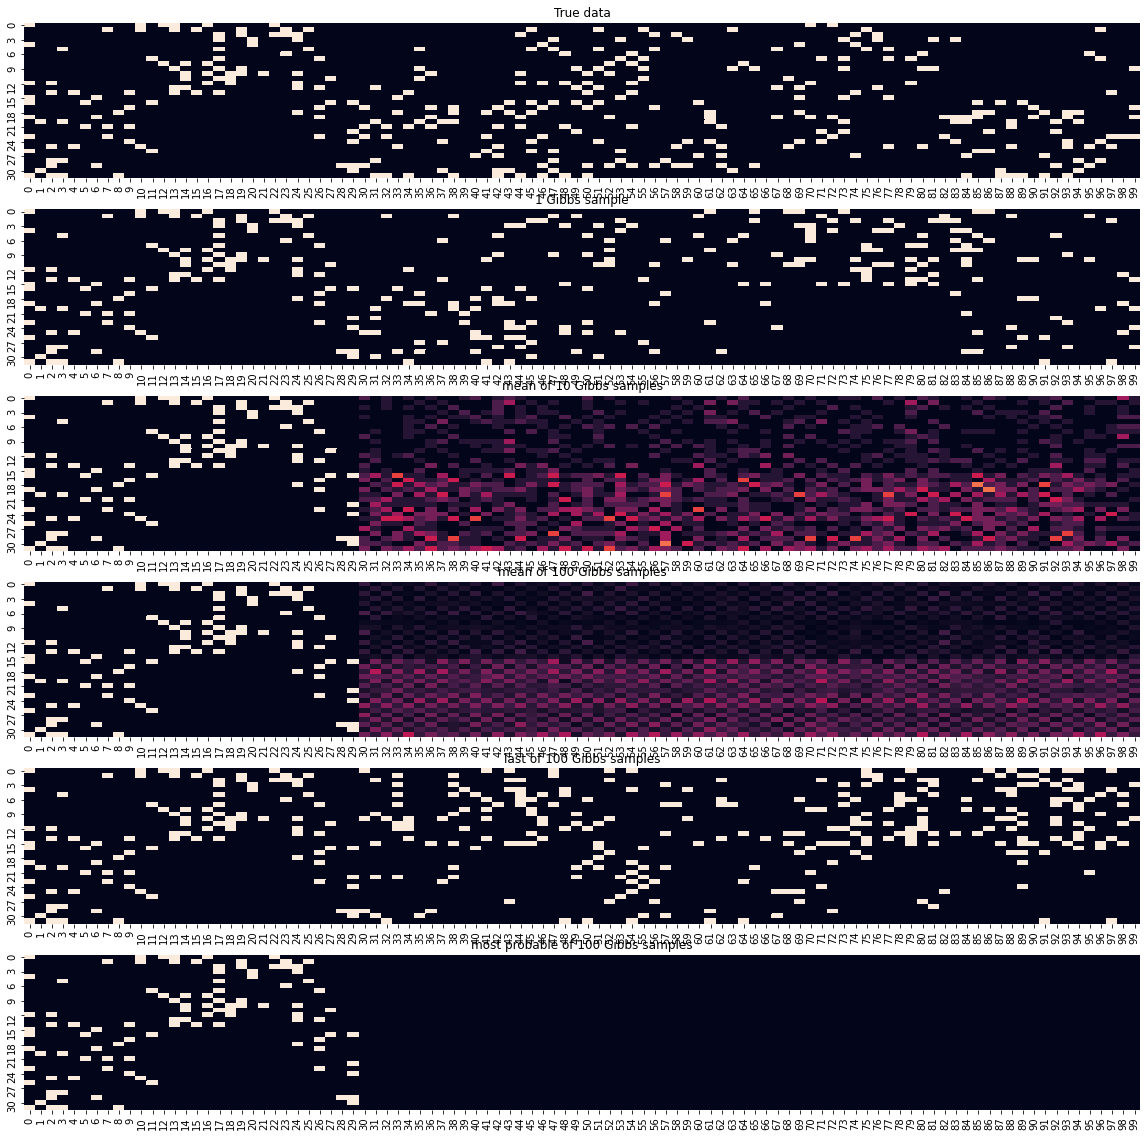

In [4]:
N_H = 8

rtrbm = RTRBM(data, N_H)
rtrbm.learn(learning_rate=1e-3, n_epochs=100, batchsize=2)

plot_different_infer(rtrbm, data[:,:,0], t_start_infer=30, t_extra=0)

RTRBM learn binary network dynamics, and learns directed transitions (mean of 100 Gibbs samples is proof of this). The even number of neurons activates the uneven number of neurons and the other way around